## Imports

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import json
import matplotlib.pyplot as plt

In [2]:
%run ../iu_xray.py

In [3]:
reports_dir = os.path.join(DATASET_DIR, 'reports')

## Load data

In [29]:
reports_fname = os.path.join(reports_dir, 'reports.json')
with open(reports_fname, 'r') as f:
    reports_as_dict = json.load(f)
    reports = list(reports_as_dict.values())
len(reports_as_dict), len(reports)

(3955, 3955)

In [30]:
info_fname = os.path.join(DATASET_DIR, 'info.json')
with open(info_fname, 'r') as f:
    info = json.load(f)
len(info)

2

In [31]:
info

{'classification': {'CXR2323_IM-0895-2001.png': 'lateral-left',
  'CXR1946_IM-0615-1001.png': 'frontal',
  'CXR544_IM-2148-1002.png': 'lateral-left',
  'CXR1402_IM-0257-3001.png': 'lateral-left',
  'CXR573_IM-2171-12012.png': 'frontal',
  'CXR1947_IM-0616-1001.png': 'frontal',
  'CXR3136_IM-1475-1001.png': 'frontal',
  'CXR37_IM-1847-0001-0002.png': 'frontal',
  'CXR3979_IM-2038-2001.png': 'lateral-left',
  'CXR188_IM-0569-1002.png': 'lateral-left',
  'CXR1775_IM-0508-1001.png': 'frontal',
  'CXR518_IM-2131-2001.png': 'lateral-left',
  'CXR2202_IM-0811-1002.png': 'lateral-left',
  'CXR3541_IM-1733-0001-0002.png': 'frontal',
  'CXR2855_IM-1263-1001.png': 'frontal',
  'CXR3807_IM-1917-1001.png': 'frontal',
  'CXR531_IM-2140-2001.png': 'lateral-left',
  'CXR1279_IM-0185-1001.png': 'frontal',
  'CXR2780_IM-1218-1003.png': 'lateral-left',
  'CXR3225_IM-1525-2001.png': 'lateral-left',
  'CXR3533_IM-1726-2001.png': 'lateral-left',
  'CXR901_IM-2409-3001.png': 'frontal',
  'CXR3016_IM-1392-200

In [65]:
with open(info_fname, 'w') as f:
    json.dump(info, f)

In [34]:
info['marks']['rotated_left']

['CXR947_IM-2442-1001.png',
 'CXR994_IM-2478-1001.png',
 'CXR2146_IM-0766-13013.png']

### Rotate images

NOTE: are already rotated!!

In [55]:
rotations = [
    ('left', -90),
    ('right', 90),
    ('bottom', 180),
]

In [ ]:
for key, degrees in rotations:
    images_key = f'rotated_{key}'
    for image_name in info['marks'][images_key]:
        filepath = os.path.join(DATASET_DIR, 'images', image_name)
        img = Image.open(filepath).rotate(degrees)
        # img.save(filepath)

## Clean text

### Tokenize and clean

In [35]:
import re

In [26]:
text = 'The previously<BR>described XXXX deformity'
re.sub(r'< ?br ?\\?>', ' ', text.lower())

'the previously described xxxx deformity'

In [36]:
def text_to_tokens(text):
    text = text.lower()
    text = re.sub(r'(\[)?&amp;[gl]t;(\])?', ' ', text)
    
    text = re.sub(r'(;|,+)', r',', text)
    
    # text = re.sub(r'\d+\.\d+', NUMBER_TOKEN, text)
    # text = re.sub(r'\d+(nd|th)?', NUMBER_TOKEN, text)
    
    text = re.sub(r'< ?br ?\\?>', ' ', text)
    text = re.sub(r'[\[\]<>]', '', text)
    text = re.sub(r'(\(|\))', r' \1 ', text)
    
    text = re.sub(r'\.+', r'.', text)
    text = re.sub(r'([a-zA-Z])(\.|,|/)', r'\1 \2', text)
    text = re.sub(r'(\.|,|/)([a-zA-Z])', r'\1 \2', text)
    
    return text.split()

In [37]:
IGNORE_TOKENS = set(['p.m.'])
token_appearances = dict()
errors = {
    'findings-none': [],
    'impression-none': [],
    'text-none': [],
    'no-images': [],
}

cleaned_reports_as_dict = dict()

for report in reports:
    filename = report['filename']
    findings = report['findings']
    impression = report['impression']

    n_images = len(report['images'])
    if n_images == 0:
        errors['no-images'].append(filename)
        continue
    
    text = findings
    if findings is None and impression is None:
        errors['text-none'].append(filename)
        continue
    elif findings is None:
        errors['findings-none'].append(filename)
        text = impression
    elif impression is None:
        errors['impression-none'].append(filename)

    # Clean and tokenize text
    tokens = [token for token in text_to_tokens(text) if token not in IGNORE_TOKENS]

    for token in tokens:
        if token not in token_appearances:
            token_appearances[token] = 0
        token_appearances[token] += 1

    cleaned_report = {k: v for k, v in report.items()}
    cleaned_report['clean_text'] = ' '.join(tokens)

    cleaned_reports_as_dict[filename] = cleaned_report

print({k: len(v) for k, v in errors.items()})
print(len(token_appearances))
len(cleaned_reports_as_dict), len(reports)

{'findings-none': 489, 'impression-none': 6, 'text-none': 25, 'no-images': 104}
1922


(3826, 3955)

In [38]:
len([k for k, v in token_appearances.items() if v > 1])

1300

In [39]:
sorted([(k, v) for k, v in token_appearances.items() if re.search(r'[()]', k)],
       key=lambda x:x[1], reverse=False)

[(')', 13), ('(', 14)]

### Review errors

In [40]:
reports_as_dict[errors['no-images'][0]]

{'comparison': 'None',
 'filename': '1068.xml',
 'findings': 'Heart size and pulmonary vascularity are within normal limits. No focal infiltrate, pneumothorax or pleural effusion is identified.',
 'images': [],
 'impression': 'No active disease.',
 'indication': 'Chest congestion',
 'tags_auto': [],
 'tags_manual': ['normal']}

### Review specific tokens

In [42]:
found = []

for report in reports:
    name = report['filename']
    text = report['findings']
    
    clean = report.get('clean_text', None)
    if not clean:
        try:
            clean = cleaned_reports_as_dict[name]['clean_text']
        except:
            pass
    
    if text is None:
        continue
        
    s = re.search('[\[\]><]', text)
    if s: #and 'and/or' not in text:
        found.append((name, text, clean)) # s.group(0)

print(len(found))
found

3


[('2192.xml',
  'No focal lung consolidation. No pneumothorax or pleural effusion.Heart size and pulmonary vascularity are within normal limits.Minimal degenerative changes of the thoracic spine. The previously<BR>described XXXX deformity in the midthoracic spine is again seen. There is subcutaneous shunt catheter tubing along the anterior chest wall',
  'no focal lung consolidation . no pneumothorax or pleural effusion . heart size and pulmonary vascularity are within normal limits . minimal degenerative changes of the thoracic spine . the previously described xxxx deformity in the midthoracic spine is again seen . there is subcutaneous shunt catheter tubing along the anterior chest wall'),
 ('2513.xml',
  '[<Heart size and pulmonary vascularity within normal limits. There is a large hiatal hernia seen projecting in the retrocardiac region. This is XXXX from prior examination. There is associated atelectasis in the left lung base. No pleural effusion or pneumothorax is identified.',
 

### Save cleaned reports

NOTE: Save after image info below

In [43]:
fname = os.path.join(reports_dir, 'reports.clean.json')
with open(fname, 'w') as f:
    json.dump(cleaned_reports_as_dict, f)

## Add side to image info (in cleaned reports)

`side` can be one of (`frontal`, `lateral-left`, `lateral-right`)

In [44]:
fname = os.path.join(reports_dir, 'reports.clean.json')
with open(fname, 'r') as f:
    clean_reports = json.load(f)
len(clean_reports)

3826

In [45]:
wrong_images = set(info['marks']['wrong'])
broken_images = set(info['marks']['broken'])

In [46]:
for report_name, report_dict in clean_reports.items():
    new_images_info = []
    for image_info in report_dict['images']:
        image_name = image_info['id']
        image_name = f'{image_name}.png'

        image_info['side'] = info['classification'][image_name]
        image_info['wrong'] = image_name in wrong_images
        image_info['broken'] = image_name in broken_images

        new_images_info.append(image_info)
    
    report_dict['images'] = new_images_info
    clean_reports[report_name] = report_dict
    
len(clean_reports)

3826

In [47]:
fname = os.path.join(reports_dir, 'reports.clean.json')
with open(fname, 'w') as f:
    json.dump(clean_reports, f)

## Save common vocab

In [88]:
import json

In [89]:
train_dataset = IUXRayDataset(dataset_type='train')
len(train_dataset)

5923

In [90]:
vocab = train_dataset.get_vocab()
len(vocab)

1775

In [92]:
with open('../vocab/iu_xray.vocab.json', 'w') as f:
    json.dump(vocab, f, indent=4)

## Calculate image normalization

In [86]:
import torch
from tqdm.notebook import tqdm

In [88]:
image_folder = os.path.join(DATASET_DIR, 'images')

In [89]:
image_names = os.listdir(image_folder)
image_names = [i for i in image_names if i.endswith('.png')]
len(image_names)

7470

In [90]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [93]:
summed = torch.zeros(3, 256, 256)

for image_name in tqdm(image_names):
    fpath = os.path.join(image_folder, image_name)
    image = transform(Image.open(fpath).convert('RGB'))
    summed += image
    
summed /= len(image_names)

In [94]:
summed.mean(dim=-1).mean(dim=-1)

tensor([0.4822, 0.4822, 0.4822])

In [95]:
summed.std(dim=-1).std(dim=-1)

tensor([0.0461, 0.0461, 0.0461])

## Test `IUXrayDataset` class

In [40]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms

In [64]:
%run ../iu_xray.py

In [65]:
dataset = IUXRayDataset()
len(dataset), len(dataset.word_to_idx)

(5923, 1775)

In [60]:
item = dataset[0]
image = item.image
labels = item.labels
report = item.report
image.size(), labels.size(), len(report)

(torch.Size([3, 512, 512]), torch.Size([14]), 4)

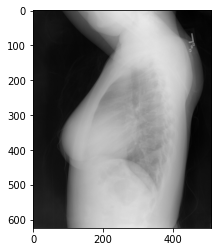

In [10]:
plt.imshow(image.numpy().transpose(1, 2, 0))

In [66]:
dataset.get_labels_presence_for('Cardiomegaly')

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (10, 0),
 (11, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (18, 0),
 (19, 0),
 (20, 1),
 (21, 1),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0),
 (29, 0),
 (30, 0),
 (31, 0),
 (32, 0),
 (33, 0),
 (34, 0),
 (35, 0),
 (36, 0),
 (37, 0),
 (38, 0),
 (39, 0),
 (40, 0),
 (41, 0),
 (42, 0),
 (43, 1),
 (44, 1),
 (45, 0),
 (46, 0),
 (47, 0),
 (48, 0),
 (49, 0),
 (50, 0),
 (51, 0),
 (52, 0),
 (53, 0),
 (54, 0),
 (55, 0),
 (56, 0),
 (57, 0),
 (58, 0),
 (59, 0),
 (60, 0),
 (61, 0),
 (62, 0),
 (63, 0),
 (64, 0),
 (65, 0),
 (66, 0),
 (67, 0),
 (68, 0),
 (69, 0),
 (70, 0),
 (71, 0),
 (72, 1),
 (73, 1),
 (74, 0),
 (75, 0),
 (76, 0),
 (77, 0),
 (78, 0),
 (79, 1),
 (80, 0),
 (81, 0),
 (82, 0),
 (83, 0),
 (84, 0),
 (85, 0),
 (86, 0),
 (87, 0),
 (88, 0),
 (89, 0),
 (90, 0),
 (91, 0),
 (92, 0),
 (93, 0),
 (94, 0),
 (95, 0),
 (96, 0),
 (97, 0),
 (98, 0),
 (99, 0),
 (100, 0),

### Review different image shapes

In [205]:
shapes = set()

for idx in range(len(dataset)):
    image, _ = dataset[idx]
    shapes.add(image.numpy().shape)

len(shapes)

251

In [206]:
shapes

{(3, 378, 512),
 (3, 391, 512),
 (3, 392, 512),
 (3, 399, 512),
 (3, 403, 512),
 (3, 409, 512),
 (3, 413, 512),
 (3, 415, 512),
 (3, 419, 512),
 (3, 420, 512),
 (3, 421, 512),
 (3, 422, 512),
 (3, 423, 512),
 (3, 424, 512),
 (3, 425, 512),
 (3, 426, 512),
 (3, 428, 512),
 (3, 429, 512),
 (3, 430, 512),
 (3, 431, 512),
 (3, 433, 512),
 (3, 434, 512),
 (3, 435, 512),
 (3, 436, 512),
 (3, 437, 512),
 (3, 441, 512),
 (3, 442, 512),
 (3, 443, 512),
 (3, 446, 512),
 (3, 447, 512),
 (3, 448, 512),
 (3, 449, 512),
 (3, 450, 512),
 (3, 451, 512),
 (3, 454, 512),
 (3, 456, 512),
 (3, 457, 512),
 (3, 459, 512),
 (3, 460, 512),
 (3, 461, 512),
 (3, 462, 512),
 (3, 463, 512),
 (3, 464, 512),
 (3, 466, 512),
 (3, 467, 512),
 (3, 468, 512),
 (3, 469, 512),
 (3, 470, 512),
 (3, 471, 512),
 (3, 472, 512),
 (3, 473, 512),
 (3, 474, 512),
 (3, 475, 512),
 (3, 476, 512),
 (3, 478, 512),
 (3, 479, 512),
 (3, 480, 512),
 (3, 481, 512),
 (3, 482, 512),
 (3, 483, 512),
 (3, 484, 512),
 (3, 485, 512),
 (3, 486

### Load single images

In [11]:
fname = DATASET_DIR + '/images/CXR5_IM-2117-1003002.png'
img = Image.open(fname)
img_tensor = transforms.ToTensor()(img)
img.size, img_tensor.size()

((512, 621), torch.Size([3, 621, 512]))

## Normal vs abnormal tags

In [14]:
from collections import defaultdict

In [15]:
counter = defaultdict(lambda: 0)
for report in reports:
    tags = report['tags_manual']
    for tag in tags:
        counter[tag] += 1

In [23]:
len(reports)

3955

In [22]:
sorted(((k, v) for k, v in counter.items()), key=lambda x:x[1], reverse=True)

[('normal', 1391),
 ('Lung/hypoinflation', 245),
 ('Lung/hyperdistention', 164),
 ('Cardiomegaly', 157),
 ('Cardiomegaly/mild', 135),
 ('Aorta/tortuous', 126),
 ('Spine/degenerative', 115),
 ('Thoracic Vertebrae/degenerative', 114),
 ('Granulomatous Disease', 98),
 ('Atherosclerosis/aorta', 97),
 ('No Indexing', 95),
 ('Thoracic Vertebrae/degenerative/mild', 93),
 ('Technical Quality of Image Unsatisfactory ', 86),
 ('Calcinosis/aorta', 69),
 ('Markings/bronchovascular', 68),
 ('Aorta, Thoracic/tortuous', 59),
 ('Catheters, Indwelling/right', 54),
 ('Emphysema', 54),
 ('Pulmonary Congestion', 52),
 ('Pulmonary Atelectasis/base/left', 51),
 ('Pulmonary Disease, Chronic Obstructive', 50),
 ('Spondylosis/thoracic vertebrae', 49),
 ('Spine/degenerative/mild', 48),
 ('Cardiomegaly/borderline', 47),
 ('Opacity/lung/base/left', 46),
 ('Pulmonary Atelectasis/base/bilateral', 44),
 ('Lung/hyperdistention/mild', 40),
 ('Implanted Medical Device/left', 39),
 ('Diaphragm/right/elevated', 38),
 ('C

## Inspect sentences

In [4]:
%run ../../utils/nlp.py

In [5]:
from collections import Counter

In [6]:
def split_sentences(report, end_token='.'):
    report = report.split()
    if report[-1] != end_token:
        report.append(end_token)

    sentences = []
    sentence = []
    for word in report:
        sentence.append(word)
        if word == end_token:
            sentences.append(sentence)
            sentence = []
            
    return [' '.join(s) for s in sentences]

In [7]:
reports_fname = os.path.join(reports_dir, 'reports.clean.json')
with open(reports_fname, 'r') as f:
    reports_as_dict = json.load(f)
    reports = list(reports_as_dict.values())
len(reports_as_dict), len(reports)

(3826, 3826)

In [11]:
synonyms_mapping = {}

### Synonyms

In [66]:
synonyms = [
    (
        'the lungs are clear',
        'lungs clear',
        'lungs are clear',
        'the lungs are clear bilaterally',
        'both lungs are clear and expanded',
        'clear lungs',
        'lungs are clear bilaterally',
        'the lungs appear clear',
    ),
    (
        'heart size normal',
        'the heart size is normal',
        'heart size is normal',
        'the heart is normal in size',
        'heart size within normal limits',
        'normal heart size',
        'heart size is within normal limits',
        'normal heart',
        'heart size is now normal',
        'the heart is of normal size',
        'the heart is normal in size and contour',
        'the heart size is within normal limits',
        'the heart is normal size',
    ),
    (
        'no pneumothorax or pleural effusion',
        'no pleural effusion or pneumothorax',
        'there is no pleural effusion or pneumothorax',
        'no pleural effusion or pneumothorax is seen',
        'no pleural effusions or pneumothoraces',
        'there is no pneumothorax or pleural effusion',
        'there is no pneumothorax or large pleural effusion',
        'there is no effusion or pneumothorax',
        'there is no pneumothorax or effusion',
        'there is no evidence of pneumothorax',
    ),
    (
        'no pneumothorax',
        'there is no pneumothorax',
        'no visible pneumothorax',
        'no visualized pneumothorax',
    ),
    (
        'no pleural effusions',
        'no pleural effusion',
        'no effusions',
        'no large pleural effusion',
        'there is no pleural effusion',
        'no large pleural effusions',
    ),
]

In [67]:
synonyms_mapping = {}
to_sentence = lambda s: s + ' .' if not s.endswith(' .') else s
for group in synonyms:
    representative = to_sentence(group[0])
    for syn in group[1:]:
        syn = to_sentence(syn)
        synonyms_mapping[syn] = representative

In [37]:
l[:20]

[('the lungs are clear .', 357),
 ('no pneumothorax .', 263),
 ('lungs are clear .', 234),
 ('heart size normal .', 180),
 ('no pneumothorax or pleural effusion .', 176),
 ('heart size is normal .', 173),
 ('the heart is normal in size .', 172),
 ('no pleural effusion or pneumothorax .', 136),
 ('the mediastinum is unremarkable .', 133),
 ('there is no pleural effusion or pneumothorax .', 129),
 ('the lungs are clear bilaterally .', 105),
 ('heart and mediastinum normal .', 103),
 ('no pleural effusion or pneumothorax is seen .', 103),
 ('heart size within normal limits .', 103),
 ('both lungs are clear and expanded .', 102),
 ('normal heart size .', 101),
 ('no pleural effusion .', 96),
 ('no pleural effusions or pneumothoraces .', 96),
 ('there is no pneumothorax .', 87),
 ('specifically , no evidence of focal consolidation , pneumothorax , or pleural effusion .',
  82)]

In [39]:
[s for s in l if 'heart' in s[0]]

[('heart size normal .', 180),
 ('heart size is normal .', 173),
 ('the heart is normal in size .', 172),
 ('heart and mediastinum normal .', 103),
 ('heart size within normal limits .', 103),
 ('normal heart size .', 101),
 ('the heart size and pulmonary vascularity appear within normal limits .',
  70),
 ('the heart size is normal .', 70),
 ('the heart and lungs have xxxx xxxx in the interval .', 65),
 ('the heart is normal in size and contour .', 52),
 ('the heart and mediastinum are normal .', 44),
 ('heart size is within normal limits .', 44),
 ('normal heart size and mediastinal contours .', 42),
 ('the heart , pulmonary xxxx and mediastinum are within normal limits .', 40),
 ('heart size and pulmonary vascularity appear within normal limits .', 37),
 ('heart and mediastinum of normal size and contour .', 37),
 ('heart size and pulmonary vascularity within normal limits .', 33),
 ('heart size and mediastinal contour are normal .', 27),
 ('the heart and pulmonary xxxx are normal .

### Count sentences

In [12]:
sentence_counter = Counter()
for report in reports:
    for sentence in split_sentences(report['clean_text']):
        sentence = synonyms_mapping.get(sentence, sentence)
        sentence_counter[sentence] += 1

In [13]:
len(sentence_counter)

6448

In [15]:
l = list(sentence_counter.items())
l = sorted(l, key=lambda x: x[1], reverse=True)
l[:20]

[('the lungs are clear .', 357),
 ('no pneumothorax .', 263),
 ('lungs are clear .', 234),
 ('heart size normal .', 180),
 ('no pneumothorax or pleural effusion .', 176),
 ('heart size is normal .', 173),
 ('the heart is normal in size .', 172),
 ('no pleural effusion or pneumothorax .', 136),
 ('the mediastinum is unremarkable .', 133),
 ('there is no pleural effusion or pneumothorax .', 129),
 ('the lungs are clear bilaterally .', 105),
 ('heart and mediastinum normal .', 103),
 ('no pleural effusion or pneumothorax is seen .', 103),
 ('heart size within normal limits .', 103),
 ('both lungs are clear and expanded .', 102),
 ('normal heart size .', 101),
 ('no pleural effusion .', 96),
 ('no pleural effusions or pneumothoraces .', 96),
 ('there is no pneumothorax .', 87),
 ('specifically , no evidence of focal consolidation , pneumothorax , or pleural effusion .',
  82)]

In [16]:
sum(t[1] for t in l)

17533

In [17]:
l[120:140]

[('the xxxx are unremarkable .', 23),
 ('no acute osseous findings .', 23),
 ('no visualized pneumothorax .', 23),
 ('there is no focal airspace consolidation .', 23),
 ('negative for acute bone abnormality .', 23),
 ('degenerative changes in the thoracic spine .', 23),
 ('the pleural spaces are clear .', 22),
 ('no pneumothorax , pleural effusion , or focal airspace disease .', 22),
 ('the cardiomediastinal silhouette and vasculature are within normal limits for size and contour .',
  22),
 ('xxxx xxxx and lateral chest examination was obtained .', 22),
 ('the visualized bony structures reveal no acute abnormalities .', 22),
 ('mild cardiomegaly .', 22),
 ('degenerative changes are present in the spine .', 22),
 ('there are atherosclerotic changes of the aorta .', 22),
 ('the heart size is within normal limits .', 21),
 ('degenerative changes in the spine .', 21),
 ('xxxx are unremarkable .', 21),
 ('there is no pleural effusion , pneumothorax , or focal airspace disease .',
  20),
 (

### Label sentences with chexpert labels

In [42]:
%run -n ../../eval_report_generation_chexpert_labeler.py

In [43]:
columns = ['sentences', 'appearances']
df_sentences = pd.DataFrame(list(sentence_counter.items()), columns=columns)
print(len(df_sentences))
df_sentences.head()

6448


,sentences,appearances
0,the cardiac silhouette and mediastinum size ar...,6
1,there is no pulmonary edema .,12
2,there is no focal consolidation .,34
3,there are no xxxx of a pleural effusion .,3
4,there is no evidence of pneumothorax .,23


In [44]:
%%time

labels = _apply_labeler_to_column(df_sentences, 'sentences')
labels.shape

Labelling sentences...
CPU times: user 47.5 ms, sys: 15.9 ms, total: 63.4 ms
Wall time: 8min 44s


(6448, 14)

In [45]:
df_sentences = _concat_df_matrix(df_sentences, labels)
df_sentences.head()

,sentences,appearances,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,the cardiac silhouette and mediastinum size ar...,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,there is no pulmonary edema .,12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,there is no focal consolidation .,34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,there are no xxxx of a pleural effusion .,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,there is no evidence of pneumothorax .,23,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
fpath = os.path.join(reports_dir, 'sentences_with_chexpert_labels.csv')
df_sentences.to_csv(fpath, index=False)

#### Analyze chexpert labels

In [50]:
snt_normal = df_sentences[df_sentences['No Finding'] == 1]
snt_abnormal = df_sentences[df_sentences['No Finding'] == 0]
len(snt_normal), len(snt_abnormal)

(3306, 3142)

In [54]:
snt_normal['appearances'].sum()

13302

In [56]:
snt_abnormal['appearances'].sum()

4231

### Number of abnormal sentences per report

In [65]:
is_sentence_normal = dict()
for index, row in df_sentences.iterrows():
    sentence = row['sentences']
    is_normal = row['No Finding']
    is_sentence_normal[sentence] = is_normal
len(is_sentence_normal)

6448

In [69]:
res = []
for report in reports:
    number_of_abnormal = sum(
        1 - is_sentence_normal[sentence]
        for sentence in split_sentences(report['clean_text'])
    )
    res.append(number_of_abnormal)
len(res)

3826

(array([1.502e+03, 1.176e+03, 6.420e+02, 3.320e+02, 0.000e+00, 1.220e+02,
        3.100e+01, 1.600e+01, 4.000e+00, 1.000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

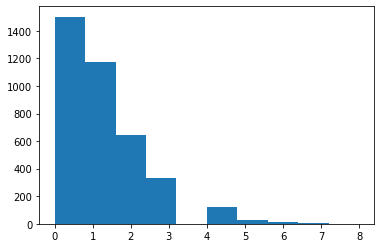

In [70]:
plt.hist(res)

### Plot sentences appearances distribution

In [18]:
values = [t[1] for t in l]

<BarContainer object of 6448 artists>

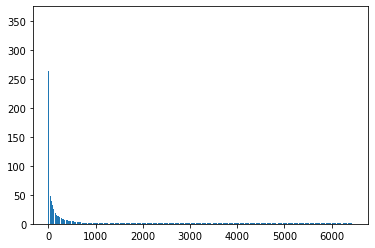

In [19]:
plt.bar(list(range(len(values))), values)

### Max amounts

#### Max amount of words in a sentence

In [76]:
sorted([(len(s.split()), s) for s in sentence_counter], reverse=True)

[(47,
  'in the left superior lower lobe there is a 1.9 x 1.8 cm round area of density which has increased in size compared to prior chest radiograph and recommend a xxxx chest , abdomen and pelvis with contrast as this area is suspicious for potential malignancy .'),
 (45,
  'there are multiple overlying leads at the level of the left lower chest , with overlying xxxx xxxx or clothing there is this is thought to account for mild increased density the left lung base on ap view , with correlate on lateral view .'),
 (38,
  'there are xxxx xxxx pulmonary opacities with blunting of the bilateral costophrenic xxxx , on the right greater than left , with pleural thickening versus loculated pleural fluid along the peripheral aspect of the right upper lobe .'),
 (36,
  'there are acute mild anterior xxxx deformities identified at l1-l2. there is retropulsion of the posterior vertebral body of l1. a ct of the lumbar spine was already ordered at the time of this dictation .'),
 (35,
  'the infr

In [82]:
47

47

#### Max amount of words

In [83]:
max(len(report['clean_text'].split()) for report in reports)

186

#### Max amount of sentences

In [86]:
max(len(split_sentences(report['clean_text'])) for report in reports)

18

## Apply chexpert labeler

TODO: use methods in `eval_rg_chexpert_labeler.py` to do this

### Create labels

In [51]:
fname = os.path.join(reports_dir, 'reports.clean.json')
with open(fname, 'r') as f:
    clean_reports = list(json.load(f).values())
len(clean_reports)

3826

In [52]:
filenames = []

with open('./reports_for_chexpert.csv', 'w') as f_csv:
    for report in clean_reports:
        name = report['filename']
        filenames.append(name)

        clean_text = report['clean_text']
        f_csv.write(f'"{clean_text}"\n')

In [58]:
filenames[0]

'1.xml'

In [59]:
import pandas as pd

In [81]:
df = pd.read_csv('./output.csv')
df = df.fillna(-2)
df['filename'] = filenames
df.head(2)

,Reports,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,filename
0,the cardiac silhouette and mediastinum size ar...,1.0,0.0,0.0,-2.0,-2.0,0.0,0.0,-2.0,-2.0,0.0,0.0,-2.0,-2.0,-2.0,1.xml
1,the cardiomediastinal silhouette is within nor...,-2.0,0.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,-2.0,-2.0,-2.0,10.xml


In [82]:
df.to_csv('./reports_with_chexpert_labels.csv')

In [76]:
clean_reports[107]

{'comparison': None,
 'filename': '1098.xml',
 'findings': 'The lungs are hyperinflated with coarse interstitial markings compatible with obstructive pulmonary disease and emphysema. There is chronic pleural-parenchymal scarring within the lung bases. No lobar consolidation is seen. No pleural effusion or pneumothorax. Heart size is normal.',
 'images': [{'caption': 'Xray Chest PA and Lateral',
   'id': 'CXR1098_IM-0067-1001',
   'side': 'frontal',
   'wrong': False,
   'broken': False}],
 'impression': 'Emphysema.',
 'indication': 'Feet XXXX.',
 'tags_auto': ['emphysemas',
  'obstructive pulmonary diseases',
  'scarring',
  'Emphysema',
  'Pulmonary Disease, Obstructive',
  'Pulmonary Emphysema'],
 'tags_manual': ['Lung/hyperdistention',
  'Markings/lung/interstitial',
  'Emphysema',
  'Pulmonary Disease, Chronic Obstructive',
  'Cicatrix/pleura/base/bilateral/chronic'],
 'clean_text': 'the lungs are hyperinflated with coarse interstitial markings compatible with obstructive pulmonary

In [78]:
a = df.loc[df['filename'] == '1098.xml', 'Reports']
type(a)

pandas.core.series.Series

In [79]:
a.values

array(['the lungs are hyperinflated with coarse interstitial markings compatible with obstructive pulmonary disease and emphysema . there is chronic pleural-parenchymal scarring within the lung bases . no lobar consolidation is seen . no pleural effusion or pneumothorax . heart size is normal .'],
      dtype=object)

### Inspect labels

In [57]:
import os
import pandas as pd

In [58]:
%run ../iu_xray.py
%run ../common.py

In [59]:
path = os.path.join(reports_dir, 'reports_with_chexpert_labels.csv')

In [60]:
df = pd.read_csv(path, index_col=0)
df = df.replace([-1, -2], 0)
df.head()

,Reports,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,filename
0,the cardiac silhouette and mediastinum size ar...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.xml
1,the cardiomediastinal silhouette is within nor...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.xml
2,both lungs are clear and expanded . heart and ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.xml
3,there is xxxx increased opacity within the rig...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.xml
4,interstitial markings are diffusely prominent ...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001.xml


In [5]:
len(df['filename']), len(set(df['filename']))

(3826, 3826)

In [16]:
labels_by_report = dict()
for index, row in df.iterrows():
    filename = row['filename']
    labels = row[CHEXPERT_LABELS].to_numpy()
    
    labels_by_report[filename] = labels

In [14]:
filename = row['filename']
filename

'1.xml'

In [15]:
labels = row[CHEXPERT_LABELS].to_numpy()
labels

array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0], dtype=object)

### Check if splits are balanced

In [75]:
def load_split_file(split_name):
    filepath = os.path.join(reports_dir, f'{split_name}.txt')
    with open(filepath, 'r') as f:
        return [
            l.strip()
            for l in f.readlines()
        ]

In [78]:
reports_by_split = dict()
for split_name in ['train', 'test', 'val']:
    report_names = load_split_file(split_name)
    reports_by_split[split_name] = report_names

In [97]:
def add_split_name(row):
    filename = row['filename']
    split_name = None
    for s, vals in reports_by_split.items():
        if filename in vals:
            split_name = s
            break
    row['split'] = split_name
    return row

In [99]:
df = df.apply(add_split_name, axis=1)
df.head()

,Reports,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,filename,split
0,the cardiac silhouette and mediastinum size ar...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.xml,train
1,the cardiomediastinal silhouette is within nor...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.xml,train
2,both lungs are clear and expanded . heart and ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.xml,train
3,there is xxxx increased opacity within the rig...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.xml,train
4,interstitial markings are diffusely prominent ...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001.xml,train


In [100]:
Counter(df['split'])

Counter({'train': 3062, 'val': 382, 'test': 382})

In [102]:
res = dict()
for split in reports_by_split.keys():
    sub_df = df[df['split'] == split]
    
    # Amounts
    n_total = len(sub_df)
    n_normal = sub_df['No Finding'].sum()
    n_abnormal = n_total - n_normal
    
    res[split] = (n_normal, n_abnormal, n_normal / n_total * 100, n_abnormal/n_total*100)
res

{'train': (1215.0, 1847.0, 39.67994774657087, 60.32005225342913),
 'test': (133.0, 249.0, 34.81675392670157, 65.18324607329843),
 'val': (154.0, 228.0, 40.31413612565445, 59.68586387434554)}

## Get sample reports

For LATINX in AI workshop

In [17]:
import matplotlib.pyplot as plt

In [18]:
import numpy as np
from pycocoevalcap.bleu import bleu_scorer
from pycocoevalcap.rouge import rouge

In [19]:
%run ../common.py
%run ../iu_xray.py
%run ../../utils/nlp.py
%run ../../utils/__init__.py

In [20]:
CONSTANT_REPORT = """the heart is normal in size . the mediastinum is unremarkable . 
the lungs are clear .
there is no pneumothorax or pleural effusion . no focal airspace disease .
no pleural effusion or pneumothorax ."""

In [9]:
dataset = IUXRayDataset(dataset_type='all')
report_reader = ReportReader(dataset.get_vocab())
len(dataset)

7426

the cardiac silhouette is mildly enlarged . a lobulated opacity is identified superior to the heart , in the anterior mediastinum on the lateral view , possibly consistent with a tortuous / ectatic thoracic aorta versus an anterior mediastinal mass . the thoracic aorta is tortuous and calcified . no focal areas of pulmonary consolidation . the lungs are hyperexpanded with flattening of the bilateral hemidiaphragms . no pneumothorax or pleural effusion . severe degenerative changes of the thoracic spine .


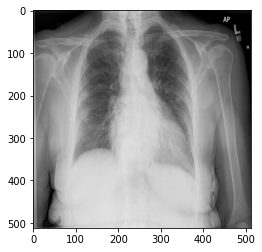

In [108]:
item = dataset[GT_IDX]
image = arr_to_range(item.image.permute(1, 2, 0))
report_base = report_reader.idx_to_text(item.report)
plt.imshow(image)
print(report_base)

In [83]:
GT_IDX = 7289

In [90]:
target = [
    'the cardiac silhouette is normal',
    # 'the lungs are hyper',
    # 'the heart is',
]
not_target = [
    # 'the lungs are clear',
#     'the mediastinum is unremarkable',
#     'the mediastinum is stable',
#     'the mediastinum is normal',
#     'the mediastinum is within normal limits',
]
found = []
found_names = set()
for idx, report in enumerate(dataset.reports):
    filename = report['filename']
    report = report_reader.idx_to_text(report['tokens_idxs'])
    if all(t in report for t in target) and all(t not in report for t in not_target):
        if filename not in found_names:
            found.append((idx, report))
        found_names.add(filename)
len(found)

6

In [98]:
found[0]

(3227,
 'the cardiac silhouette is normal in size and configuration . the mediastinum and perihilar structures appear unremarkable . the lungs appear clear . the osseous structures are within normal limits .')

In [143]:
gen = 'the heart is enlarged. the mediastinum is unremarkable . the lungs are hyperinflated with mildly coarsened interstitial markings . '
# the lungs are hyperexpanded
# the lungs are hyperinflated with mildly coarsened interstitial markings
# the lungs are hyperinflated with biapical pleural-parenchymal scarring and upward retraction of the xxxx

In [33]:
def measure_bleu_rouge(gen, gt):
    scorer = bleu_scorer.BleuScorer(n=4)
    scorer += (gen, [gt])
    bleu_1_4, _ = scorer.compute_score()
    
    scorer = rouge.Rouge()
    rouge_score = scorer.calc_score([gen], [gt])
    
    print('BLEU 1-4: ', bleu_1_4)
    print('BLEU: ', np.mean(bleu_1_4))
    print('ROUGE: ', rouge_score)

In [34]:
report_1 = """the heart is normal in size . the mediastinum is unremarkable . 
the lungs are clear ."""
report_2 = """the heart is normal . the mediastinum is otherwise unremarkable . 
lungs are both clear ."""
measure_bleu_rouge(report_1, report_2)

BLEU 1-4:  [0.823529411716263, 0.6806139096884855, 0.498031475650019, 0.36447528422896314]
BLEU:  0.5916625203209327
ROUGE:  0.7922077922077921


In [86]:
report = report_reader.idx_to_text(dataset[GT_IDX].report)
report

'the cardiac silhouette is mildly enlarged . a lobulated opacity is identified superior to the heart , in the anterior mediastinum on the lateral view , possibly consistent with a tortuous / ectatic thoracic aorta versus an anterior mediastinal mass . the thoracic aorta is tortuous and calcified . no focal areas of pulmonary consolidation . the lungs are hyperexpanded with flattening of the bilateral hemidiaphragms . no pneumothorax or pleural effusion . severe degenerative changes of the thoracic spine .'

In [109]:
gt = """the cardiac silhouette is enlarged .
the lungs are hyperexpanded with flattening of the bilateral hemidiaphragms .
no pneumothorax or pleural effusion ."""
# the lungs are hyperinflated with mildly coarsened interstitial markings .

In [110]:
gen = """the cardiac silhouette is normal in size and configuration .
the lungs are clear .
no pneumothorax or pleural effusion ."""

In [111]:
measure_bleu_rouge(gen, gt)

BLEU 1-4:  [0.6493974591358048, 0.5951826025196549, 0.5343297171373826, 0.46369919062449266]
BLEU:  0.5606522423543338
ROUGE:  0.644191714053615


In [102]:
measure_bleu_rouge(gen, gt)

BLEU 1-4:  [0.6199575199238246, 0.5715725916560236, 0.5164217737904286, 0.4512727516288187]
BLEU:  0.5398061592497739
ROUGE:  0.7011494252873564
